In [0]:
!pip install tensorflow-gpu==1.15.0 # GPU Version

# Import

In [0]:
import os
import tensorflow as tf
import time
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

# check tensorflow version
print(tf.__version__)
# Confirm tensorflow can see the GPU
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

1.15.0
Found GPU at: /device:GPU:0


In [0]:
#222 images data image of shape 512*512=262144
#images_size = 262144
X = tf.placeholder(tf.float32, shape=[None, 262144])
Z = tf.placeholder(tf.float32, shape=[None, 100])

# Set up parameters for generator and discriminator

In [0]:
# Generator
# Define the variables for the generator, we will use them to build layers later
# -------------------
size_g_w1 = 100
size_g_b1 = 512
# A good way to decide the std for initializing the weights
w1_std = 1.0/tf.sqrt(size_g_w1/2.0)

G_W1 = tf.Variable(tf.random_normal(shape=[size_g_w1, size_g_b1], stddev=w1_std))
G_b1 = tf.Variable(tf.zeros(shape=[size_g_b1]))

size_g_w2 = 512
size_g_b2 = 262144
w2_std = 1.0/tf.sqrt(size_g_w2/2.0)

G_W2 = tf.Variable(tf.random_normal(shape=[size_g_w2, size_g_b2], stddev=w2_std))
G_b2 = tf.Variable(tf.zeros(shape=[size_g_b2]))
# theta_G and theta_D will be feeded to different optimizers later as "var_list", 
# since currently we have two networks instead of one now.
theta_G = [G_W1, G_W2, G_b1, G_b2]

# ====================
# Discriminator
# Define the variables for the discriminator
# --------------------
size_d_w1 = 262144
size_d_b1 = 512
w1_std = 1.0/tf.sqrt(size_d_w1/2.0)

D_W1 = tf.Variable(tf.random_normal(shape=[size_d_w1,size_d_b1], stddev=w1_std))
D_b1 = tf.Variable(tf.zeros(shape=[size_d_b1]))

size_d_w2 = 512
size_d_b2 = 1
w2_std = 1.0/tf.sqrt(size_d_w2/2.0)

D_W2 = tf.Variable(tf.random_normal(shape=[size_d_w2,size_d_b2], stddev=w2_std))
D_b2 = tf.Variable(tf.zeros(shape=[size_d_b2]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator module

In [0]:
def generator(z):

    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_logit)

    return G_prob, G_logit


# Discriminator module

In [0]:
def discriminator(x):

    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

# Generate samples function

In [0]:
def sample_z(m, n):
    # randomly generate samples for generator
    return np.random.uniform(-1.0, 1.0, size = [m, n])

# Plotting samples

In [0]:
def plot_sample(samples, size1, size2):
    
    fig1 = plt.figure(figsize=(size1, size2))
    gs = gridspec.GridSpec(size1, size2)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(512, 512), cmap='gray')
        # plt.imshow(sample.reshape(28, 28), cmap='gray')

    return fig1

# Faciliate the path defining process

In [0]:
# Though it's not possible to get the path to the notebook by __file__, os.path is still very useful in dealing with paths and files
# In this case, we can use an alternative: pathlib.Path
"""
code_dir   = os.path.dirname(__file__)
"""

#get the current path of our code
code_dir = Path().resolve()
#create output_dir within the same path
output_dir = os.path.join(code_dir, 'Problem1_a/')
if not os.path.isdir(output_dir):
   os.makedirs(output_dir)

# Use all images with random shuffling for training the GAN

In [0]:
def next_batch(data, num):
    '''
    Return a total of `num` random samples 
    '''
    #print(len(data))
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = np.array([data[i] for i in idx])

    return data_shuffle

# Read image file from given path

In [0]:
sizePixel1 = 512
sizePixel2 = sizePixel1*sizePixel1
size_d = 32

def read_tensor_from_image_file(path, input_height=sizePixel1, input_width=sizePixel1, input_mean=0, input_std=255):
    
    input_name = "file_reader"
    output_name = "normalized"
    file_reader = tf.read_file(path, input_name)
    image_reader = tf.image.decode_png(file_reader, channels = 1)
    float_caster = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0);
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.Session()
    result = sess.run(normalized)
    return result 


nSeries = 222
numInSeries = 1
nImages = nSeries*numInSeries #222
img  = np.zeros((nImages, sizePixel1*sizePixel1))
counter = 0

#get the current path of our code
folder = Path().resolve()
print('current path:',folder)

for j in range(0,numInSeries):
    for i in range(1,nSeries+1):
        # print(counter,i,j)
        fname = str(i) + '_' + str(j) + '.png'
        path = './data/' + fname
        orig_img = read_tensor_from_image_file(path)
        # vectorize
        img[counter] = orig_img.reshape(-1)
        
        # original size
        # img[counter] = orig_img.reshape(sizePixel1,sizePixel1)
        counter = counter+1

print('Input image shape is:', img.shape)

current path: /content
Input image shape is: (222, 262144)


# Build GNN with defined vars and functions

In [0]:
# Put randomly generated sample Z into the generator to create "fake" images
G_sample, _ = generator(Z)
# The result of discriminator of real and fake samples
_, D_logit_real = discriminator(X)
_, D_logit_fake = discriminator(G_sample)

# generator loss 
# the goal of generator is to let discriminator make more mistakes on fake samples
# tf.ones_like returns a tensor with all elements set to 1
# 0 represent fake and 1 means real
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# discriminator loss 
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Start the session

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 64
# the dimension of the random samples
z_dim = 100
result_freq = 300
# plot generators' output every figure_iter step
figure_iter = 300
max_iter = 30000
size1 = 5
size2 = 5
i = 0

discriminator_loss = np.empty(max_iter)
generator_loss = np.empty(max_iter)

for iter in range(max_iter):
    
    if iter % figure_iter == 0:
        
        # G_sample is a sample from the generator
        samples = sess.run(G_sample, feed_dict={Z: sample_z(size1*size2, z_dim)})

        fig1 = plot_sample(samples, size1, size2)
        plt.savefig(output_dir + 'Problem1_a_' + str(i) + '.png', bbox_inches='tight')
        i += 1
        plt.close(fig1)

    # batch_xs, _ = mnist.train.next_batch(batch_size)
    batch_xs = next_batch(img, batch_size)

    _, discriminator_loss[iter] = sess.run([D_solver, D_loss], feed_dict={X: batch_xs, Z: sample_z(batch_size, z_dim)})
    _, generator_loss[iter]     = sess.run([G_solver, G_loss], feed_dict={Z: sample_z(batch_size, z_dim)})

    if iter % result_freq == 0:
        
        print('iteration: {}'.format(iter))
        print('D_loss: {:0.4}'.format(discriminator_loss[iter]))
        print('G_loss: {:0.4}'.format(generator_loss[iter]))
        print()

iteration: 0
D_loss: 1.679
G_loss: 508.1

iteration: 300
D_loss: 10.77
G_loss: 1.379e+03

iteration: 600
D_loss: 0.001937
G_loss: 494.5

iteration: 900
D_loss: 39.61
G_loss: 508.7

iteration: 1200
D_loss: 1.932
G_loss: 322.7

iteration: 1500
D_loss: 36.31
G_loss: 175.8

iteration: 1800
D_loss: 9.365
G_loss: 25.86

iteration: 2100
D_loss: 58.07
G_loss: 79.37

iteration: 2400
D_loss: 0.0001637
G_loss: 63.51

iteration: 2700
D_loss: 1.069
G_loss: 125.1

iteration: 3000
D_loss: 4.331
G_loss: 74.3

iteration: 3300
D_loss: 0.5744
G_loss: 79.26

iteration: 3600
D_loss: 1.159
G_loss: 89.39

iteration: 3900
D_loss: 0.02072
G_loss: 49.34

iteration: 4200
D_loss: 0.000607
G_loss: 48.85

iteration: 4500
D_loss: 1.05
G_loss: 58.82

iteration: 4800
D_loss: 0.7763
G_loss: 106.9

iteration: 5100
D_loss: 1.115
G_loss: 58.22

iteration: 5400
D_loss: 0.2532
G_loss: 82.37

iteration: 5700
D_loss: 0.8361
G_loss: 49.32

iteration: 6000
D_loss: 0.1982
G_loss: 40.8

iteration: 6300
D_loss: 0.0028
G_loss: 41.9

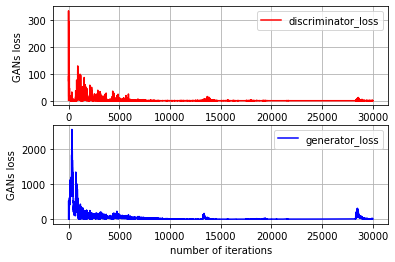

In [13]:
plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(np.arange(max_iter), discriminator_loss, 'r-', label='discriminator_loss')
plt.xlabel('number of iterations')
plt.ylabel('GANs loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(max_iter), generator_loss, 'b-', label='generator_loss')
plt.xlabel('number of iterations')
plt.ylabel('GANs loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
!zip -r /content/Problem1_a.zip /content/Problem1_a
# !zip -r /content/file.zip /content/Folder_To_Zip
# from google.colab import files
# files.download("/content/file.zip")


  adding: content/Problem1_a/ (stored 0%)
  adding: content/Problem1_a/Problem1_a_16.png (deflated 4%)
  adding: content/Problem1_a/Problem1_a_71.png (deflated 4%)
  adding: content/Problem1_a/Problem1_a_5.png (deflated 4%)
  adding: content/Problem1_a/Problem1_a_73.png (deflated 5%)
  adding: content/Problem1_a/Problem1_a_40.png (deflated 1%)
  adding: content/Problem1_a/Problem1_a_42.png (deflated 0%)
  adding: content/Problem1_a/Problem1_a_92.png (deflated 5%)
  adding: content/Problem1_a/Problem1_a_59.png (deflated 1%)
  adding: content/Problem1_a/Problem1_a_67.png (deflated 4%)
  adding: content/Problem1_a/Problem1_a_20.png (deflated 4%)
  adding: content/Problem1_a/Problem1_a_82.png (deflated 5%)
  adding: content/Problem1_a/Problem1_a_36.png (deflated 2%)
  adding: content/Problem1_a/Problem1_a_0.png (deflated 1%)
  adding: content/Problem1_a/Problem1_a_81.png (deflated 5%)
  adding: content/Problem1_a/Problem1_a_65.png (deflated 2%)
  adding: content/Problem1_a/Problem1_a_95.pn

In [15]:
!ls
# !rm -rf /content/Problem1_a

data  Problem1_a  Problem1_a.zip  sample_data
